<a href="https://colab.research.google.com/github/hmehryar/DeepLearningTutorial/blob/main/deep_learning_tutorial_episode17_gpu_bench_marking_with_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style='color:blue'>Small Image Classification Using Simple Aritifical Neural Network: GPU Benchmarking</h2>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
# Version Information
# tensorflow 2.2.0 , Cudnn7.6.5 and Cuda 10.1 , python 3.8

**This command shows list of physical devices available for tensorflow. You can see GPU listed here. If you have NVIDIA GPU you need to install CUDA toolkit and cuDNN as per instruction on this webpage. Without proper installation you will not see GPU in list of devices**

https://shawnhymel.com/1961/how-to-install-tensorflow-with-gpu-support-on-windows/

In [ ]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
tf.test.is_built_with_cuda()

True

<h4 style="color:purple">Load the dataset</h4>

Our dataset contains 1000 small training images that belongs to one of the below 3 diffetent $\alpha_s$ classes

In [ ]:
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

In [ ]:
import os

def load_data():
  from google.colab import drive
  df=None
  # Check if Google Drive is mounted
  google_drive_path = '/content/drive/'
  if os.path.isdir(google_drive_path):
      # Google Drive is mounted, get the file from Google Drive
      file_path = '/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl'
      if os.path.exists(file_path):
          # File exists on Google Drive, load it
          df=pd.read_pickle('/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl')
      else:
          print("File does not exist on Google Drive.")
  else:
      # Google Drive is not mounted, load the file from the file system
      file_path = "G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.data\\simulation_results\\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl"
      if os.path.exists(file_path):
          # File exists on the file system, load it
          df=pd.read_pickle("G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.data\\simulation_results\\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl")
      else:
          print("File does not exist on the file system.")
  # if (drive.mount('/content/drive')==True):
  #   df=pd.read_pickle('/content/drive/MyDrive/Projects/110_JetscapeMl/hm.jetscapeml.data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl')
  # else:
  #   df=pd.read_pickle("G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.data\\simulation_results\\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl")


  from sklearn.model_selection import train_test_split
  type(df)
  dataset_x=df[0]
  dataset_y=df[1]
  dataset_x.shape
  X_train, X_test, y_train, y_test=train_test_split(dataset_x,dataset_y,test_size=0.2, random_state=None)
  return ((X_train, y_train), (X_test,y_test))


In [ ]:
((X_train, y_train), (X_test,y_test)) = load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
X_train.shape

(800, 32, 32)

In [ ]:
y_train=y_train[:,1]
y_test=y_test[:,1]

In [ ]:
y_train.shape

(800,)

<h4 style="color:purple">Data Visualization</h4>

In [ ]:
def plot_sample(index):
    plt.figure(figsize = (10,1))
    plt.imshow(X_train[index])

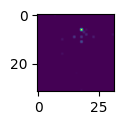

In [ ]:
plot_sample(0)

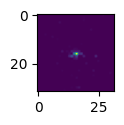

In [ ]:
plot_sample(1)

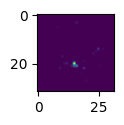

In [ ]:
plot_sample(2)

In [ ]:
classes=['0.2' ,'0.3' ,'0.4']

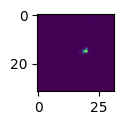

In [ ]:
plot_sample(3)

In [ ]:
y_train[3]

'0.2'

In [ ]:
# prompt: convert y_train into classes index by integer

y_train_index = [classes.index(str(y)) for y in y_train]
y_test_index = [classes.index(str(y)) for y in y_test]


In [ ]:
y_train[3]

'0.2'

In [ ]:
classes[y_train_index[3]]

'0.2'

In [ ]:
y_train[:3]

array(['0.3', '0.3', '0.2'], dtype='<U32')

In [ ]:
y_test.shape

(200,)

In [ ]:
X_train.shape

(800, 32, 32)

<h4 style="color:purple">Preprocessing: Scale images</h4>

In [ ]:
# prompt: get the max from X_train and X_test

max_value = np.max(np.concatenate((X_train, X_test), axis=0))
max_value

86.90838000000002

In [ ]:
X_train_scaled = X_train / max_value
X_test_scaled = X_test / max_value

In [ ]:
X_train_scaled[1,:].shape

(32, 32)

In [ ]:
y_train_categorical = keras.utils.to_categorical(
    y_train_index, num_classes=3, dtype='float32'
)
y_test_categorical = keras.utils.to_categorical(
    y_test_index, num_classes=3, dtype='float32'
)

In [ ]:
y_train[0:5]

array(['0.3', '0.3', '0.2', '0.2', '0.3'], dtype='<U32')

In [ ]:
y_train_categorical[0:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

<h4 style="color:purple">Model building and training</h4>

In [ ]:
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(3, activation='sigmoid')
    ])

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train_categorical, epochs=1)

25/25 [==============================] - 2s 4ms/step - loss: 1.0988 - accuracy: 0.3212


<h4 style="color:purple">Let's make some predictions</h4>

In [ ]:
np.argmax(model.predict(X_test_scaled)[0])

7/7 [==============================] - 0s 4ms/step


1

In [ ]:
y_test[0]

'0.3'

In [ ]:
def get_model():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(32,32)),
            keras.layers.Dense(3000, activation='relu'),
            keras.layers.Dense(1000, activation='relu'),
            keras.layers.Dense(3, activation='sigmoid')
        ])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

<h3 style='color:purple'>Measure training time on a CPU<h3>

In [ ]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

25/25 [==============================] - 2s 39ms/step - loss: 1.0990 - accuracy: 0.3025
1.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<h3 style='color:purple'>Lets measure training time on a GPU (I've NVIDIA Titan RTX)<h3>

In [ ]:
%%timeit -n1 -r1
with tf.device('/GPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

25/25 [==============================] - 1s 4ms/step - loss: 1.0992 - accuracy: 0.2988
1.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<h3 style='color:purple'>Lets run same test for 10 epocs<h3>

In [ ]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=10)

Epoch 1/10
25/25 [==============================] - 2s 54ms/step - loss: 1.0992 - accuracy: 0.3187
Epoch 2/10
25/25 [==============================] - 1s 53ms/step - loss: 1.0988 - accuracy: 0.3325
Epoch 3/10
25/25 [==============================] - 1s 52ms/step - loss: 1.0985 - accuracy: 0.3487
Epoch 4/10
25/25 [==============================] - 1s 45ms/step - loss: 1.0983 - accuracy: 0.3625
Epoch 5/10
25/25 [==============================] - 1s 36ms/step - loss: 1.0979 - accuracy: 0.3587
Epoch 6/10
25/25 [==============================] - 1s 36ms/step - loss: 1.0977 - accuracy: 0.3713
Epoch 7/10
25/25 [==============================] - 1s 38ms/step - loss: 1.0973 - accuracy: 0.3725
Epoch 8/10
25/25 [==============================] - 1s 35ms/step - loss: 1.0971 - accuracy: 0.3725
Epoch 9/10
25/25 [==============================] - 1s 35ms/step - loss: 1.0968 - accuracy: 0.3900
Epoch 10/10
25/25 [==============================] - 1s 36ms/step - loss: 1.0966 - accuracy: 0.3587
21 s ± 0 

In [ ]:
%%timeit -n1 -r1
with tf.device('/GPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 5ms/step - loss: 1.0986 - accuracy: 0.3325
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.0983 - accuracy: 0.3562
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 1.0979 - accuracy: 0.3762
Epoch 4/10
25/25 [==============================] - 0s 4ms/step - loss: 1.0975 - accuracy: 0.3537
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 1.0973 - accuracy: 0.3475
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 1.0971 - accuracy: 0.3363
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 1.0968 - accuracy: 0.3438
Epoch 8/10
25/25 [==============================] - 0s 5ms/step - loss: 1.0965 - accuracy: 0.3613
Epoch 9/10
25/25 [==============================] - 0s 5ms/step - loss: 1.0963 - accuracy: 0.3462
Epoch 10/10
25/25 [==============================] - 0s 4ms/step - loss: 1.0960 - accuracy: 0.3512
3.07 s ± 0 ns per l

Here is the performance comparison for 1 epoch,

| Epoch | CPU | GPU  |
|:------|:------|:------|
| 1 | 1.72 sec | 1.09 sec |
| 10 | 21 sec | 3.07 sec |

You can see that GPU is almost 7 times faster. We ran only one epoch for benchmarking but for actual training we have to run many epochs and also when data volume is big running deep learning without GPU can consume so much time. This is the reason why GPUs are becoming popular in the field of deep learning